# Thermography: data loading + visualization example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm, Normalize, SymLogNorm, CenteredNorm, LinearSegmentedColormap # -> for adjusting color map for better illumination
import os
from natsort import natsorted # to sort the numbers in strings (s.a. path) correctly (0, 1, 2, ... instead of 0, 1, 10, ...)
import cv2

In [2]:
from thermography_file_reader import ThermoFileReader
from thermography_preprocessing import ThremoDataPreprocessing, ThermoDataPreparation, ThermoIlluminationCorrection

## Data info and known parameters
File structures differ depending on the measurement sets. Threre are two groups:
* (a) 4_SampleSet, 5_SpaceCalibration, 6_SampleSet => ThermoFileReader is ready for stitching  
  = meaning, a file can be loaded by specifying the position of the desired file 
* (b) 2_SampleSet => ThermoFileReader is NOT ready for stitching (v250207)  
  = meaning, a file needs to be loaded by specifying the file number, e.g. '2_3_2'

File reading needs to be done differently

In [3]:
# Specify which type of files (see above)
load_with_positions = True # True, if files are of type (a) 

In [4]:
# ==== Type (a) data set ====
if load_with_positions == True:
    # ----- Path
    # (5) Calibration data
    #path_rel = '/Volumes/Sandisk_SD/Work/IZFP/ReMachine/Thermografie/5_SpaceCalibration/measurements/Sample_4/data'
    # (4) Screws
    screwNo = 78 #78, 85, 88
    # 4_sampleSet --> Pre-damage data 
    path_rel_1 = f'/Volumes/Sandisk_SD/Work/IZFP/ReMachine/Thermografie/4_InspectedSamples/B{screwNo}/measurements'
    # 6_SampleSet --> Post-damage data
    #path_rel_1 = f'/Volumes/Sandisk_SD/Work/IZFP/ReMachine/Thermografie/6_SampleSet_SourceData_Nach_Belastung/B{screwNo}/measurements'
    
    # ---- Array formatting params: can be found in measurement.xml
    # Image size + frames ---> will be extracted from measurements.xml
    # --> just as info: typically, (width, height, frames) = (320, 256, 75 (or 74))
    # Irrelevant area (outside the screw image)
    y_offset = 25
    xmin, xmax = 25, -25
    
    # ---- Load the file by its position
    pos_y, pos_x = (5, -2) # = file position (max, (y, x) = (8, 8)
    reader = ThermoFileReader(_path_rel_1=path_rel_1)
    data_tens, fileNo = reader.load_data(
        pos=(pos_y, pos_x), 
        ymin=y_offset, xmin=xmin, xmax=xmax, 
        ret_fileNo=True
    )
    
    print(f'fileNo = {fileNo}')

fileNo = 59


In [ ]:
# ==== Type (b) data set ====
if load_with_positions == False:
    # --- Path setting
    # 2_SampleSet: path
    # (e.g.) /Volumes/Sandisk_SD/Work/IZFP/ReMachine/Thermografie/2_SampleSet/SourceData/measurements/Sample_2_3_2/data.bin
    path_rel_1 = '/Volumes/Sandisk_SD/Work/IZFP/ReMachine/Thermografie/2_SampleSet/SourceData/measurements'
    # File number: X1_X2_X3: X1 = screw No., X2 = rotation position (1...6), X3 = vertical position (1...3)
    fileNo = '2_4_2'
    # Relative path
    path_rel = f'{path_rel_1}/Sample_{fileNo}'

    # --- Array formatting params
    # Irrelevant area (outside the screw image)
    ymin, ymax = 60, 130 # 46, 142
    xmin, xmax = 90, 260 # 100, 250

    # --- Load
    reader = ThermoFileReader(_path_rel_1=None)
    data_tens = reader.load_data(
        path_rel=path_rel, 
        ymin =ymin, ymax=ymax,
        xmin=xmin, xmax=xmax, ret_fileNo=False, 
    )

    # --- FFT reco
    proc = ThremoDataPreprocessing()
    reco = proc.reco_fft_phase(data_tens)[..., 1] # only fbin=1 is relevant
    # Zero-mean
    mean = reco.mean()
    reco = reco - mean
    

In [ ]:
#%matplotlib widget
%matplotlib inline
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

plt.suptitle(f'Sample_{fileNo}: plots are transposed and otigin=lower')
# Time domain
axs[0].imshow(data_tens[..., 40], cmap=plt.cm.gray)
axs[0].set_title(f'time domain')
# FFT reco
axs[1].imshow(reco, cmap=plt.cm.gray)
axs[1].set_title(f'FFT reco (phase)')
plt.show()

In [ ]:
#%matplotlib widget 
%matplotlib inline
plt.plot(data_tens[50:135, :, 40].T)
plt.grid(True)
plt.show()

In [ ]:
# Cehck the FFT
this_row = 50
this_col = 70
vec = data_tens[this_row, this_col, :]

fig = plt.figure(figsize=(7, 7), layout='constrained')
axs = fig.subplot_mosaic([["signal", "signal"],
                          ["magnitude", "log_magnitude"],
                          ["phase", "angle"]])

# plot time signal:
axs["signal"].set_title("Signal")
axs["signal"].plot(vec, color='C0')
axs["signal"].set_xlabel("Time (s)")
axs["signal"].set_ylabel("Amplitude")

# plot different spectrum types:
axs["magnitude"].set_title("Magnitude Spectrum")
axs["magnitude"].magnitude_spectrum(vec, color='C1')

axs["log_magnitude"].set_title("Log. Magnitude Spectrum")
axs["log_magnitude"].magnitude_spectrum(vec, scale='dB', color='C1')

axs["phase"].set_title("Phase Spectrum ")
axs["phase"].phase_spectrum(vec, color='C2')

axs["angle"].set_title("Angle Spectrum")
axs["angle"].angle_spectrum(vec, color='C2')

plt.show()

## Data centering

In [ ]:
proc = ThremoDataPreprocessing()
data_centered, shift_x = proc.centering(data_tens, ret_shiftx=True)

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes = axes.ravel()
this_frame = 40

axes[0].imshow(data_tens[:, 29:239, this_frame], cmap=plt.cm.gray)
axes[0].set_title(f'Original: file={fileNo}')

axes[1].imshow(data_centered[:, 29:239, this_frame], cmap=plt.cm.gray)
axes[1].set_title(f'Centered: est. shift_x={shift_x}')
plt.tight_layout()
plt.show()

# Data preparation

In [5]:
# Using the prepper class (can be used only with type (a) files, see above)
# --> new segment shapes are pre-defined in the class
# Select the file by its position
pos_y, pos_x = (5, -2)

prepper = ThermoDataPreparation()
prepper.reader = path_rel_1
# Load & process the data
data_proc = prepper.get_processed_data_time(pos=(pos_y, pos_x))
reco = prepper.get_reco(pos=(pos_y, pos_x))
fileNo = prepper.fileNo

ThermoFileReader.load_data: ymin is not specified, so it is set to 0
ThermoFileReader.load_data: ymin is not specified, so it is set to 0


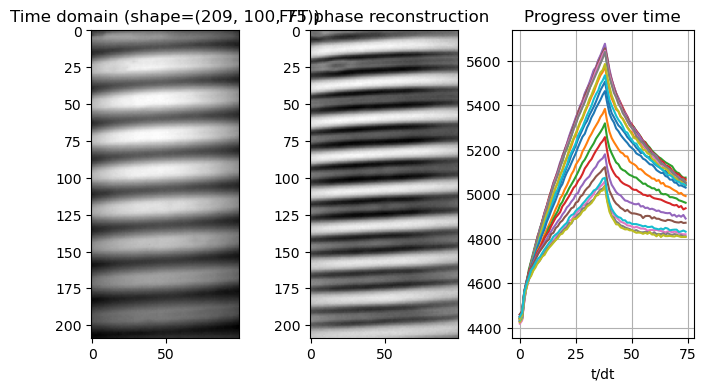

In [11]:
#%matplotlib widget
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
axs[0].imshow(data_proc[..., 40], cmap='gray')
axs[0].set_title(f'Time domain (shape={data_proc.shape})')
axs[1].imshow(reco, cmap='gray')
axs[1].set_title('FFT phase reconstruction')

axs[2].plot(data_proc[90:110, 50, :].T)
axs[2].grid(True)
axs[2].set_title('Progress over time')
axs[2].set_xlabel('t/dt')
plt.show()

In [ ]:
import pandas as pd
# Convert the reco as a pandas dataframe
df = pd.DataFrame(
    data=reco,
    index=np.arange(reco.shape[0]),
    columns=np.arange(reco.shape[1])
)

In [ ]:
import plotly.express as px

fig = px.line(
    np.abs(df.iloc[:, :10]),
    labels={
        'index': 'height (pixel)',
        'columns': 'width (pixel)'
    },
    title=f'B{screwNo}, No.{fileNo}: transition around y=158'
)
fig.show()

In [ ]:
# Find the absmax between 158 & 170 --> where the contour toward the thred starts
# start, end = 158, 170
# boundary_y = start + np.argmax(np.abs(reco[start:end, :]), axis=0)
start, end = 130, 150
boundary_y = start + np.argmin(np.abs(reco[start:end, :]), axis=0)

# Or majority vote
#unique_elements, counts = np.unique(start + np.argmax(np.abs(reco[start:end, :]), axis=0), return_counts=True)
#boundary_y = unique_elements[np.argmax(counts)]* np.ones(reco.shape[1], dtype=int)
print(boundary_y[:5])

shaft = np.copy(reco)
thred = np.copy(reco)
for col in range(reco.shape[1]):
    shaft[boundary_y[col]:, col] = np.nan
    thred[:boundary_y[col], col] = np.nan


In [ ]:
%matplotlib inline

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))

# Normalize
# Shaft
th = np.nanquantile(np.abs(shaft), 0.9) #0.005
scale = 1.0
norm = SymLogNorm(linthresh=th, linscale=scale, vmin=np.nanmin(shaft), vmax=np.nanmax(shaft), clip=False)
shaft_normed = norm.__call__(shaft)
axs[0].imshow(shaft_normed, cmap='gray')

# Thred
th = np.nanquantile(np.abs(thred), 0.9) #0.005
scale = 1.0
norm = SymLogNorm(linthresh=th, linscale=scale, vmin=np.nanmin(thred), vmax=np.nanmax(thred), clip=False)
thred_normed = norm.__call__(thred)
axs[1].imshow(thred_normed, cmap='gray')

# Merge
merged = np.nan_to_num(shaft_normed.data) + np.nan_to_num(thred_normed.data)
print(thred_normed.data.shape)
axs[2].imshow(merged, cmap='gray')


plt.show()

## Illumination correction

In [ ]:
corrector = ThermoIlluminationCorrection()
corrector.set_parameters(
    p_start = 50.0, 
    num_bins = 401, 
    window_length = 40, 
    stepsize = 5
)
thres_adap = corrector.adaptive_threshold(reco)


In [ ]:
# ==== Plot =====
#%matplotlib widget
%matplotlib inline

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 10))
plt.suptitle(f'Sample {fileNo}')

# (1) No illumination correction
axs[0].imshow(reco, cmap='gray')
axs[0].set_title('No correction')

# (2) Fixed threshold
thres_fix = np.nanquantile(np.abs(reco), 0.9)
scale = 1.0
norm_fix = SymLogNorm(
    linthresh=thres_fix, linscale=scale, 
    vmin=np.nanmin(reco), vmax=np.nanmax(reco), clip=False
)
axs[1].imshow(norm_fix.__call__(reco).data, cmap='gray')
axs[1].set_title(f'Fixed: th={round(thres_fix, 3)}')

# (3) Adaptive threshold
norm_adap = SymLogNorm(
    linthresh=thres_adap, linscale=scale, 
    vmin=np.nanmin(reco), vmax=np.nanmax(reco), clip=False
)
axs[2].imshow(norm_adap.__call__(reco).data, cmap='gray')
axs[2].set_title(f'Adaptive: th={round(thres_adap, 3)}')

plt.show()

In [ ]:
raise ValueError('Stop!')

## Save the plots of all files ---> to check the data 

In [ ]:
# List all files
all_path_rel = reader.get_files(path_rel_1, ret_structured=False)
#all_path_rel

In [ ]:
#path_save = '/Users/sayakokodera/Work/IZFP/ReMachine/plots/5_Space_Calibration'
path_save = f'/Users/sayakokodera/Work/IZFP/ReMachine/plots/4_InspectedSamples/B{screwNo}'
this_frame = 40

vmaxs = []

for fileNo, path_rel in enumerate(all_path_rel):
    # Load
    data_tens = load_data(
        path_rel, 
        y_offset=y_offset, xmin=xmin, xmax=xmax
    )
    # Plot +save
    # fsave = f'{path_save}/data_{fileNo}_frame40.png'
    # plt.imsave(fsave, data_tens[..., this_frame])
    # vmaxs.append(np.max(np.abs(data_tens), axis=(0, 1)))
    

In [ ]:
plt.imshow(np.array(vmaxs))
plt.title('Sample_4, files (1) to (71): absmax of each frame')
plt.xlabel('Frame No.')
plt.ylabel('File No.')

plt.savefig('sample4_absmaxs.png')
plt.show()

In [ ]:
int(200* 180/180) 